# Setting up a classifier for CIFAR-10 Images
For this part we're going to use typical code as suggested by [this official PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Model path:
PATH = '../Models/cifar_net.pth'

## Get the data
PyTorch provides CIFAR-10 as well as a few other standard data sets via the torchvision module, but the images they return are in the PILImage format so the pixel values are between 0 and 1. PyTorch itself prefers tensors in the normalized range [-1,1], so we normalize with the following transformation.

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../Data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


The following cell shows how to view an image from the dataset.

Matplotlib is building the font cache; this may take a moment.


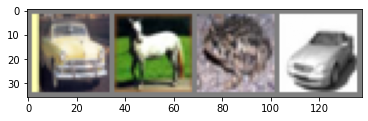

  car horse  frog   car


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Create a Classifier - Convolutional Neural Net

**You can skip this and the training steps and move on to the Model Performance subsection if you just want to try out the saved model.**

This code creates a convolutional neural net that takes as input 3-channel images.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

We'll use the loss function suggested by the tutorial, which is Cross-Entropy loss. The optimization strategy is Stochastic Gradient Descent using a non-trivial momentum.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training
The next code cell is written for CPU-training. We could adapt this for GPU training if desired, but my laptop doesn't have a GPU, so I started with this.

In [20]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.215
[1,  4000] loss: 1.180
[1,  6000] loss: 1.188
[1,  8000] loss: 1.164
[1, 10000] loss: 1.188
[1, 12000] loss: 1.178
[2,  2000] loss: 1.174
[2,  4000] loss: 1.183
[2,  6000] loss: 1.197
[2,  8000] loss: 1.199
[2, 10000] loss: 1.169
[2, 12000] loss: 1.184
[3,  2000] loss: 1.200
[3,  4000] loss: 1.194
[3,  6000] loss: 1.182
[3,  8000] loss: 1.186
[3, 10000] loss: 1.162
[3, 12000] loss: 1.189
Finished Training


The model can be saved to disk like this. 

In [21]:
torch.save(net.state_dict(), PATH)

## Model performance
Here's what we get if we pass normal test images through the classifier. If you didn't create and train the neural net classifier above, you'll want to run the next cell to load it.

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Here's a couple images we could start with.

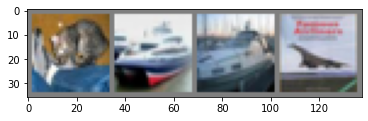

GroundTruth:    cat  ship  ship plane


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

This is what the classifier thinks the images are. The output category that is highest weight is the label the network prefers. These weights get called "energies" in the tutorial.

In [24]:
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


Now let's check the entire testing dataset.

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


The next cell shows how well the classifier does on each class.

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 66 %
Accuracy of  bird : 42 %
Accuracy of   cat : 37 %
Accuracy of  deer : 35 %
Accuracy of   dog : 49 %
Accuracy of  frog : 81 %
Accuracy of horse : 54 %
Accuracy of  ship : 75 %
Accuracy of truck : 57 %


Maybe we want to show how we can fool the classifier on ships?